# Обучение языковой модели с помощью LSTM

В этом примере мы обучим языковую модель с помощью рекуррентной нейронной сети. В отличие от предыдущего примера, мы будем работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [ ]:
# pip install datasets

In [ ]:
# pip install torch

In [ ]:
# pip install matplotlib

In [ ]:
# pip install nltk

In [ ]:
# pip install scikit-learn

In [ ]:
# pip install seaborn

In [ ]:
# pip3 install -U datasets

In [ ]:
# pip install fsspec==2022.8.2

In [ ]:
# python install pip --upgrade

In [ ]:
# pip list

In [ ]:
# pip install tensorboard

Импорт необходимых библиотек

In [10]:
import gc
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pickle
import random
import seaborn
import string
import torch
import torch.nn as nn

from collections import Counter
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from typing import List

In [2]:
# Зафиксируем сид Python
SEED = 12345
random.seed(SEED)
# Зафиксируем сид Numpy
np.random.seed(SEED)

seaborn.set(palette='summer')

In [123]:
nltk.download('punkt')

In [4]:
# Посмотрим на чем мы будем работать
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [124]:
# Загрузим датасет
dataset = load_dataset('imdb', ignore_verifications=True)

In [6]:
# Взглянем на структуру
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [8]:
# Что мы имеем
dataset['test']['text'][0]

'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as they have

### Препроцессинг данных и создание словаря

Разделим отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
Оставим только те предложения, в которых меньше ```word_threshold``` слов.

In [11]:
sentences = []
word_threshold = 32

# Получим отдельные предложения и поместим их в sentences
sentences = []
# Выставим значение в 32 слова
word_threshold = 32
for example in tqdm(dataset['train']['text']):
    # Удалим из предложений перенос строки и HTML-тег "br"
    example = example.replace('<br /><br />', ' ').replace('\n', ' ')
    for row in sent_tokenize(example):
        if len(word_tokenize(row)) < word_threshold:
            sentences.append(row.lower().translate(str.maketrans('', '', string.punctuation)))

  0%|          | 0/25000 [00:00<?, ?it/s]

In [12]:
print("Всего предложений:", len(sentences))

Всего предложений: 254301


In [13]:
# Посмотрим на первые 2 получившихся предложения
sentences[:2]

['i rented i am curiousyellow from my video store because of all the controversy that surrounded it when it was first released in 1967',
 'the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life']

Посчитаем частоту вхождения каждого слова в оставшихся предложениях. Для деления предложения на отдельные слова удобно использовать функцию ```word_tokenize```.

Посчитаем для каждого слова его встречаемость.

In [14]:
words = Counter()

# Расчет встречаемости слов
for example in tqdm(sentences):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1

  0%|          | 0/254301 [00:00<?, ?it/s]

In [15]:
# Посмотрим на 5 самых встречающихся
list(dict(words.most_common()).items())[:5]

[('the', 200470), ('a', 97965), ('and', 94467), ('of', 83348), ('to', 79357)]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

Создадим объект ```vocab``` класса ```set```, положим в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.

In [16]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# Наполнение словаря
vocab_dict = {k: v for k, v in sorted(words.items(), key=lambda item: item[1], reverse=True)}
vocab_list = list(vocab_dict.items())[:vocab_size]
for i in range(vocab_size):
    vocab.add(vocab_list[i][0])

На всякий случай проверим сами себя

In [17]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [18]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета

Далее, как и в предыдущем примере, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` реализуем метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода добавим служебные токены начала и конца последовательности, а также токенизируем соответствующее предложение с помощью ```word_tokenize``` и сопоставим ему индексы из ```word2ind```.

In [19]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [20]:
class WordDataset:
    def __init__(self, sentences: List[str]):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        # Фильтруем по той же механике, что и train выборку
        processed_text = self.data[idx].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)] 
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [21]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    '''
    Функция дополнения наших предложений, если их размер меньше
    остальных получившихся.
    На вход подаем:
    batch
    id паддинга
    На выходе:
    новый собранный batch одинаковой длины по всем предложениям
    '''
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [22]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2,
                                                   random_state=SEED)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5,
                                                   random_state=SEED)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 256

# Фиксируем сиды DataLoader-ов
num_workers = 0
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

train_dataloader = DataLoader(
    train_dataset,
    collate_fn=collate_fn_with_padding,
    shuffle=True,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g
)

eval_dataloader = DataLoader(
    eval_dataset,
    collate_fn=collate_fn_with_padding,
    shuffle=False,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g
)

test_dataloader = DataLoader(
    test_dataset,
    collate_fn=collate_fn_with_padding,
    shuffle=False,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g
)

# Создадим для удобства общий даталоадер
dataloader = {'train': train_dataloader,
              'test': test_dataloader,
              'eval': eval_dataloader}

## Обучение и архитектура модели

Проверим на практике проверить, что влияет на качество языковых моделей. Проведем серию экспериментов с различными вариантами языковых моделей и сравним различия в конечной перплексии на тестовом множестве.

Возможные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Нам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

Мы остановимся на двух схожих моделях и поэкспериментируем в размерами скрытого состояния (одинаковое изменение для обоих моделей).

После проведения экспериментов составим таблицу результатов, в которой посчитана перплексия на тестовом множестве.

### Функция evaluate

In [96]:
def evaluate(model, criterion, dataloader) -> float:
    # Модифицируем фунцию, чтобы она также выводлиа лосс на даталоадере
    model = model.to(device)
    model.eval()
    perplexity, losses = [], []
    with torch.no_grad():
        for batch in dataloader:
            # Посчитаем логиты предсказаний следующих слов
            input_ids = batch['input_ids'].flatten(start_dim=0, end_dim=1)
            target_ids = batch['target_ids'].flatten()
            logits = model(input_ids)
            loss = criterion(logits, target_ids.flatten())
            losses.append(loss.item())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)
    loss = sum(losses) / len(losses)  # Или len(dataloader)
    # Добавим вывод значения лосса на даталоадер
    return perplexity, loss

### Train loop

Начнем тренировку наших моделей

In [24]:
def train(model, dataloader, num_epoch, optimizer=None, criterion=None, sheduler=None):
    '''
    Функция обучения по эпохам
    принимает на вход: даталоадер с тренировочными данными, даталоадер с проверочными данными ,модель,
    количество эпох обучения, размер батча, оптимайзер, функцию потерь, планировщик
    отдает: лучшую модель на обучении, историю обучения
    '''        
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # будем использовать модель Adam
    if criterion is None:
        criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>']) # будем использовать кросэнтропию
    
    best_model = model.state_dict() # сохраняем все тензоры модели
    best_perplexity = None # для понимания лучшего скора модели
    
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss: {v_loss:0.4f} train_perplexity: {t_perplexity:0.4f} val_perplexity: {v_perplexity:0.4f}"

    with tqdm(desc="epoch", total=num_epoch) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = criterion
        
        for epoch in range(num_epoch):
            perplexity, losses = [], []
            for i, batch in enumerate(dataloader['train']):
                model.train()
                optimizer.zero_grad()  # обуляем градиенты модели
                logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)  # .to(device))  # получаем "логиты" из модели
                train_loss = criterion(logits, batch['target_ids'].flatten())  # считаем "лосс"  .flatten()
                train_loss.backward()
                optimizer.step()
                perplexity.append(torch.exp(train_loss).item())
                losses.append(train_loss.detach().cpu())
            train_loss = sum(losses) / len(losses)
            train_perplexity = sum(perplexity) / len(perplexity)
            val_perplexity, val_loss = evaluate(model, criterion, dataloader['eval'])
                
            history.append((epoch, train_loss, train_perplexity, val_loss, val_perplexity))

            if not best_perplexity:
                best_perplexity = val_perplexity
            if val_perplexity < best_perplexity:
                best_perplexity = val_perplexity
                best_model = model.state_dict()
                            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss.numpy(),\
                                           v_loss=val_loss, t_perplexity=train_perplexity, v_perplexity=val_perplexity))
    
    print('Best val perplexity: {:4f}'.format(best_perplexity))
    model.load_state_dict(best_model)
    return model, history

### Первый эксперимент

Возьмем модель GRU и размер скрытого состояния в 128

In [25]:
class LanguageModel(nn.Module):
    def __init__(self, type_model, hidden_dim: int, vocab_size: int):
        super().__init__()

        # Сама нейронная сеть
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        if type_model == 'GRU':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        if type_model == 'RNN':
            self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)
        
    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут живет forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [26]:
def clean_up() -> None:
    '''
    Функция очистки кэша видеопамяти
    '''
    gc.collect()
    torch.cuda.empty_cache()

In [27]:
clean_up()

In [28]:
# Обучим модель
model = LanguageModel(type_model = 'GRU', hidden_dim=128, vocab_size=len(vocab)).to(device)
model, history = train(model, dataloader, num_epoch=7)

epoch:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 001 train_loss: 6.5308     val_loss: 6.1292 train_perplexity: 1257.0853 val_perplexity: 460.1458

Epoch 002 train_loss: 5.7910     val_loss: 5.8001 train_perplexity: 329.3581 val_perplexity: 331.1493

Epoch 003 train_loss: 5.5333     val_loss: 5.7852 train_perplexity: 253.6318 val_perplexity: 326.2554

Epoch 004 train_loss: 5.3764     val_loss: 5.7628 train_perplexity: 216.6730 val_perplexity: 318.9811

Epoch 005 train_loss: 5.2657     val_loss: 5.7021 train_perplexity: 193.9650 val_perplexity: 300.1800

Epoch 006 train_loss: 5.1813     val_loss: 5.6491 train_perplexity: 178.2134 val_perplexity: 284.6424

Epoch 007 train_loss: 5.1125     val_loss: 5.7122 train_perplexity: 166.3867 val_perplexity: 303.1987
Best val perplexity: 284.642404


In [29]:
def plot_history(history: List[tuple]) -> None:
    '''
    Фукция отрисовки loss и perplexities на train и val
    '''
    epoch, loss, perplexities, val_loss, val_perplexities = zip(*history)
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    axes[0].plot(epoch, loss, label='train_loss', color='g')
    axes[0].plot(epoch, val_loss, label='val_loss', color='r')
    axes[1].plot(epoch, perplexities, label='train_score', color='g')
    axes[1].plot(epoch, val_perplexities, label='val_score', color='r')
    for i in [0,1]:
        axes[i].legend()
    return val_perplexities

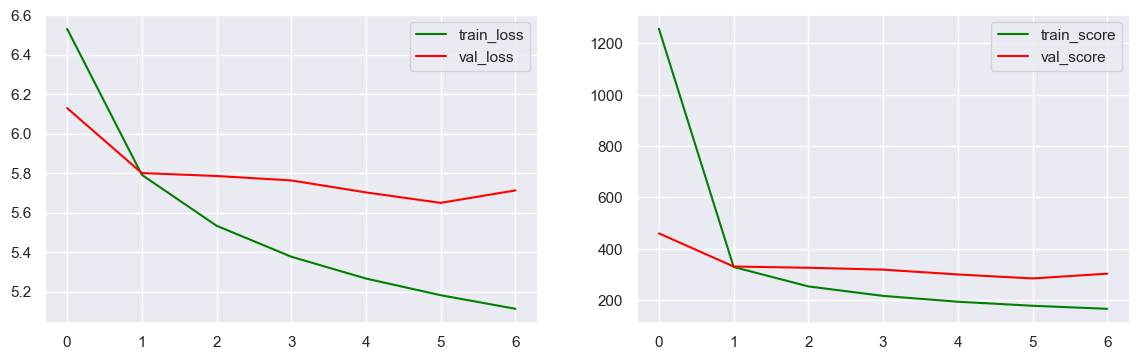

In [30]:
val_perplexities = plot_history(history)

In [31]:
results = pd.DataFrame ({'model_arch': 'GRU', 'hidden_dim': 128, 'perplexities':[min(val_perplexities)]})
results

,model_arch,hidden_dim,perplexities
0,GRU,128,284.642404


In [32]:
pickle.dump(model, open('model_LanguageModel.sav', 'wb'))

In [33]:
del model

### Второй эксперимент

Возьмем ту же модель, но увеличим размер скрытого состояния до 256

In [34]:
clean_up()

In [35]:
model = LanguageModel(type_model = 'GRU', hidden_dim=256, vocab_size=len(vocab)).to(device)
model, history = train(model, dataloader, num_epoch=7)

epoch:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 001 train_loss: 6.3487     val_loss: 6.2781 train_perplexity: 935.7022 val_perplexity: 534.2609

Epoch 002 train_loss: 5.5825     val_loss: 6.4174 train_perplexity: 267.5354 val_perplexity: 614.3839

Epoch 003 train_loss: 5.2943     val_loss: 6.4154 train_perplexity: 199.6987 val_perplexity: 613.1218

Epoch 004 train_loss: 5.1122     val_loss: 6.2294 train_perplexity: 166.3593 val_perplexity: 508.8847

Epoch 005 train_loss: 4.9765     val_loss: 6.2074 train_perplexity: 145.2268 val_perplexity: 497.7649

Epoch 006 train_loss: 4.8660     val_loss: 6.1643 train_perplexity: 130.0417 val_perplexity: 476.6920

Epoch 007 train_loss: 4.7725     val_loss: 6.1273 train_perplexity: 118.4216 val_perplexity: 459.3198
Best val perplexity: 459.319761


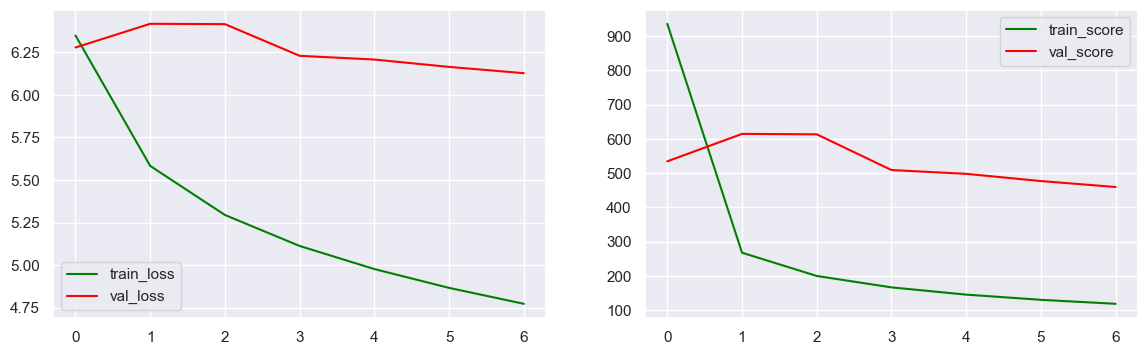

In [36]:
val_perplexities = plot_history(history)

In [37]:
results.loc[1] = ['GRU', '256', min(val_perplexities)]
results

,model_arch,hidden_dim,perplexities
0,GRU,128,284.642404
1,GRU,256,459.319761


In [38]:
pickle.dump(model, open('model_LanguageModel_hd.sav', 'wb'))

In [39]:
del model

### Третий эксперимент

Возьмем модель RNN с размером скрытого состояния в 128

In [40]:
clean_up()

In [41]:
model = LanguageModel(type_model = 'RNN', hidden_dim=128, vocab_size=len(vocab)).to(device)
model, history = train(model, dataloader, num_epoch=7)

epoch:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 001 train_loss: 6.5273     val_loss: 5.9520 train_perplexity: 1277.2472 val_perplexity: 385.3848

Epoch 002 train_loss: 5.7870     val_loss: 5.6297 train_perplexity: 327.8105 val_perplexity: 279.2080

Epoch 003 train_loss: 5.5478     val_loss: 5.4498 train_perplexity: 257.3903 val_perplexity: 233.2134

Epoch 004 train_loss: 5.4057     val_loss: 5.3270 train_perplexity: 223.1314 val_perplexity: 206.2500

Epoch 005 train_loss: 5.3037     val_loss: 5.2307 train_perplexity: 201.4580 val_perplexity: 187.3091

Epoch 006 train_loss: 5.2251     val_loss: 5.1635 train_perplexity: 186.1958 val_perplexity: 175.1132

Epoch 007 train_loss: 5.1606     val_loss: 5.1078 train_perplexity: 174.5496 val_perplexity: 165.6084
Best val perplexity: 165.608443


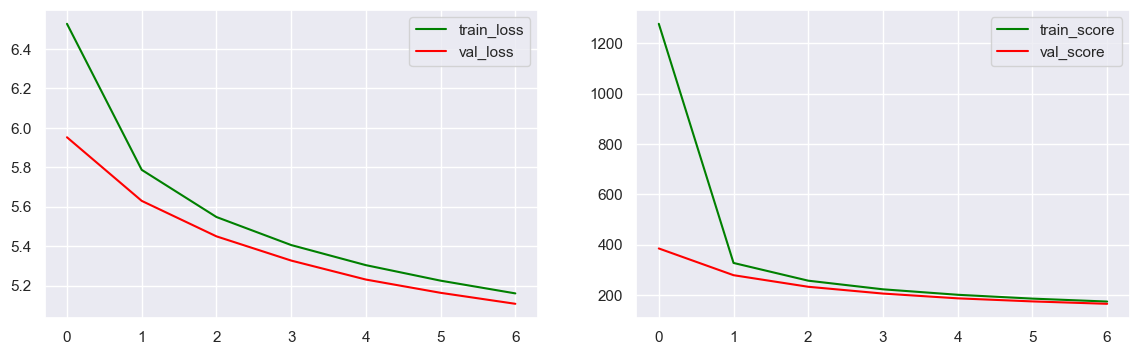

In [42]:
val_perplexities = plot_history(history)

In [43]:
results.loc[2] = ['RNN', '128', min(val_perplexities)]
results

,model_arch,hidden_dim,perplexities
0,GRU,128,284.642404
1,GRU,256,459.319761
2,RNN,128,165.608443


In [44]:
pickle.dump(model, open('model_WordRNN.sav', 'wb'))

In [45]:
del model

### Четвертый эксперимент

На той же модели потренируем с размером скрытого состоянием в 256

In [46]:
clean_up()

In [47]:
model = LanguageModel(type_model = 'RNN', hidden_dim=256, vocab_size=len(vocab)).to(device)
model, history = train(model, dataloader, num_epoch=7)

epoch:   0%|          | 0/7 [00:00<?, ?it/s]


Epoch 001 train_loss: 6.2922     val_loss: 5.7642 train_perplexity: 907.8041 val_perplexity: 319.3879

Epoch 002 train_loss: 5.5841     val_loss: 5.5271 train_perplexity: 267.5027 val_perplexity: 251.9643

Epoch 003 train_loss: 5.3273     val_loss: 5.3621 train_perplexity: 206.3493 val_perplexity: 213.5817

Epoch 004 train_loss: 5.1631     val_loss: 5.2171 train_perplexity: 175.0284 val_perplexity: 184.7379

Epoch 005 train_loss: 5.0412     val_loss: 5.1617 train_perplexity: 154.9458 val_perplexity: 174.7582

Epoch 006 train_loss: 4.9423     val_loss: 5.0213 train_perplexity: 140.3543 val_perplexity: 151.8522

Epoch 007 train_loss: 4.8590     val_loss: 4.9518 train_perplexity: 129.1283 val_perplexity: 141.6649
Best val perplexity: 141.664857


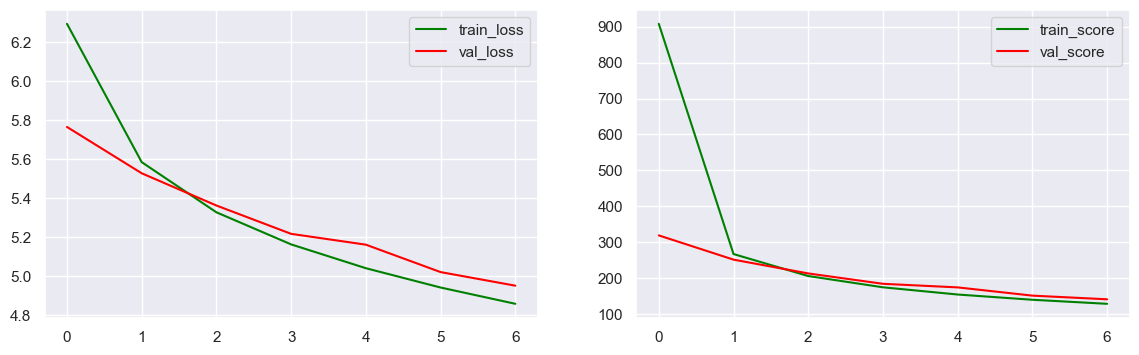

In [48]:
val_perplexities = plot_history(history)

In [49]:
results.loc[3] = ['RNN', '256', min(val_perplexities)]
results

,model_arch,hidden_dim,perplexities
0,GRU,128,284.642404
1,GRU,256,459.319761
2,RNN,128,165.608443
3,RNN,256,141.664857


In [50]:
pickle.dump(model, open('model_WordRNN_hd.sav', 'wb'))

In [51]:
del model

In [52]:
clean_up()

### Вывод

В обоих экспериментах мы, для частоты пробы, крутили сетки по 7 эпох.
В первом эксперименте мы использовали GRU, во втором RRN.
В обоих случаях архитектура сеток по слоям, не считая архитектур самих сеток, схожа.
Изначально взял GRU, т.к. это уже не сеть прямого распространения, как RNN. У нее уже есть попытка избавиться от затухания (взрывания градиента).
GRU - разновидность LSTM. У них на один фильтр меньше, и они немного иначе соединены: вместо входного, выходного фильтров и фильтра забывания здесь используется фильтр обновления (update gate). Этот фильтр определяет сколько информации сохранить от последнего состояния и сколько информации получить от предыдущего слоя. Фильтр сброса состояния (reset gate) работает почти так же, как фильтр забывания, но расположен немного иначе. На следующие слои отправляется полная информация о состоянии: выходного фильтра здесь нет. В большинстве случаем GRU работают так же, как RNN, самое значимое отличие в том, что GRU немного быстрее и проще в эксплуатации (однако обладает немного меньшими выразительными возможностями).
Сравнение RNN и GRU мне показалось уместным.
Осталось проверить, как они ведут себя на тестовых даннных и немного наглядности.

#### Посмотрим на предсказание

In [97]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)
    
    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break
    
    words = ' '.join([ind2word[idx.item()] for idx in input_ids])
    device = 'cuda'
    return words

In [98]:
model = pickle.load(open('model_LanguageModel.sav', 'rb')) 

In [99]:
generate_sequence(model, starting_seq='It may treat important issues')

'<bos> <unk> may treat important issues <eos>'

#### А какие результаты нам покажет данная модель на test?

In [100]:
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [101]:
perplexities, loss = evaluate(model, criterion, dataloader['test'])
perplexities_test = [perplexities]
perplexities_test

[337.28994852292465]

In [102]:
del model

In [103]:
clean_up()

#### Посмотрим на результат работы второй модели

In [104]:
model = pickle.load(open('model_LanguageModel_hd.sav', 'rb')) 

In [105]:
generate_sequence(model, starting_seq='It may treat important issues')

'<bos> <unk> may treat important issues <eos>'

In [106]:
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [107]:
perplexities, loss = evaluate(model, criterion, dataloader['test'])
perplexities_test.append(perplexities)
perplexities_test

[337.28994852292465, 557.7122955629284]

In [108]:
del model

In [109]:
clean_up()

#### Следующая модель

In [110]:
model = pickle.load(open('model_WordRNN.sav', 'rb')) 

In [111]:
generate_sequence(model, starting_seq='It may treat important issues')

'<bos> <unk> may treat important issues that the movie is a great movie <eos>'

In [118]:
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [112]:
perplexities, loss = evaluate(model, criterion, dataloader['test'])
perplexities_test.append(perplexities)
perplexities_test

[337.28994852292465, 557.7122955629284, 187.34936670806087]

In [113]:
del model

In [114]:
clean_up()

#### Проверим на последней

In [115]:
model = pickle.load(open('model_WordRNN_hd.sav', 'rb')) 

In [116]:
generate_sequence(model, starting_seq='It may treat important issues')

'<bos> <unk> may treat important issues and the characters are very good <eos>'

In [117]:
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [119]:
perplexities, loss = evaluate(model, criterion, dataloader['test'])
perplexities_test.append(perplexities)
perplexities_test

[337.28994852292465, 557.7122955629284, 187.34936670806087, 177.4052028847892]

In [120]:
del model

In [121]:
clean_up()

In [122]:
results['test_perpkixity'] = perplexities_test
results

,model_arch,hidden_dim,perplexities,test_perpkixity
0,GRU,128,284.642404,337.289949
1,GRU,256,459.319761,557.712296
2,RNN,128,165.608443,187.349367
3,RNN,256,141.664857,177.405203


Как видно по результату, модель RNN показала себя лучше, чем GRU, причем, если с увеличением размера скрытого состояния модель GRU вела себя значительно хуже, то модель RNN - наоборот, показывала лучшие результаты